<a href="https://colab.research.google.com/github/mengyaoo/FNL_GenesSelection/blob/main/08_TC1_Reduced_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the libraries

In [1]:
from __future__ import print_function

import os, sys, gzip, glob, json, time, argparse
import pandas as pd
import numpy as np
import keras
from pandas.io.json import json_normalize

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.manifold as sk_manif
from keras.utils import to_categorical
from google.colab import drive
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation   

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Read features and output files 
TC1data15 = pd.read_csv("/content/drive/My Drive/FNL_TC1/TC1-S1-data15-genename.tsv", sep="\t", low_memory = False)

In [5]:
# dftm_FPKM_UQ = pd.read_csv('/content/drive/My Drive/FNL_TC1/dftm_FPKM_UQ.tsv', sep='\t', low_memory=False)

In [6]:
outcome = pd.read_csv('/content/drive/My Drive/FNL_TC1/TC1-outcome-data15-projectname.tsv', sep='\t')

In [7]:
def encode(data): 
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [8]:
# outcome = encode(outcome['Project_id'])

In [9]:
TC1data15['project_id_name'] = outcome['Project_id_name']
TC1data15['project_id'] = outcome['Project_id']


In [10]:
TC1data15

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,1.897300,0.000000,1.829995,0.656801,0.001333,0.528604,2.618544,1.993496,1.487510,1.049062,0.000000,0.258848,1.455348,0.853410,1.215961,0.000000,0.571925,0.644190,0.536399,0.215012,0.0,1.704930,2.033992,2.059344,0.000000,0.000000,0.0,0.0,0.811806,1.861269,1.084387,2.724172,1.159409,0.000000,0.000000,0.193960,1.282674,0.685311,0.463778,0.899169,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [11]:
TC1data15_reduced = TC1data15[(TC1data15['project_id_name'] != 'TCGA-CESC') & (TC1data15['project_id_name'] != 'TCGA-LUSC') & (TC1data15['project_id_name'] != 'TCGA-BLCA') & (TC1data15['project_id_name'] != 'TCGA-HNSC')]

In [12]:
TC1data15_reduced

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1,project_id_name,project_id
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TCGA-OV,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,1.093695,0.000000,1.988667,0.283733,0.364344,0.877896,1.329502,1.897314,1.163299,1.300965,0.127528,0.663284,1.314699,0.541920,1.580328,0.796438,1.206176,0.443063,0.907488,0.377302,0.0,1.346724,1.743430,1.933017,0.538718,1.370868,0.0,0.0,1.180550,1.875021,0.858495,1.702392,1.042091,0.396351,1.043403,1.391530,1.063549,0.630927,1.128599,1.089357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

# ConvNN

## Train/Test split    

In [13]:
# from keras.utils import to_categorical
TC1data15_selected = TC1data15_reduced.iloc[:,:-2]
outcome = encode(TC1data15_reduced['project_id'])
TC1data15_selected.shape, outcome.shape

Shape of data (BEFORE encode): (3300,)
Shape of data (AFTER  encode): (3300, 15)



((3300, 60483), (3300, 15))

In [14]:
TC1data15_selected

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
0,1.829525,0.000000,2.062846,0.913543,0.809255,0.365063,1.315347,1.936558,0.657487,1.437908,0.551174,0.719120,1.393872,1.118917,1.987483,0.000000,1.393437,0.257243,1.161696,1.141140,0.0,1.644513,1.765476,2.090856,0.549029,0.718534,0.0,0.0,0.750320,1.912752,1.141035,1.480509,1.567273,0.164270,0.101726,1.313405,1.158674,1.141063,0.798311,1.360485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.541309,0.000000,1.815986,0.593689,0.557331,0.608742,1.376983,1.592561,0.569209,1.103958,0.478385,1.033488,1.008026,0.758012,1.681421,1.453353,1.018066,0.223281,0.788680,0.693349,0.0,2.098755,1.643610,2.391891,0.884490,0.000000,0.0,0.0,1.128794,1.836294,0.778508,1.743826,1.415378,0.000000,0.173718,0.749825,1.539502,0.676204,0.761320,0.964733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.282789,0.000000,1.895928,0.571531,0.332523,0.576545,1.171834,1.351888,0.836259,1.423673,0.200690,0.874702,0.876875,0.904634,1.109651,0.617534,0.904555,0.000000,0.724887,0.834916,0.0,1.567345,1.350662,2.029576,0.246144,2.193634,0.0,0.0,0.820252,1.581194,0.813868,1.547321,1.086540,0.000000,0.000000,0.464639,1.080810,0.456927,0.652686,0.725820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.388260,0.000000,1.905475,0.399374,0.259750,0.219200,0.494936,1.822393,0.619865,0.793788,0.221321,0.567275,1.334915,0.984844,1.915951,0.458862,0.611663,0.000000,0.341496,0.735198,0.0,1.955291,1.635719,2.151499,0.000000,1.956215,0.0,0.0,0.867816,1.938688,1.049283,2.416171,1.523516,0.000000,0.000000,0.663285,0.998184,0.468721,0.456932,0.606861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.389160,0.530588,2.316735,0.349455,0.189075,0.623428,0.801534,1.685248,0.784901,0.922292,0.489743,0.968513,1.126255,0.844110,0.942073,0.000000,0.995927,0.169634,0.783794,0.614325,0.0,2.429317,1.840638,2.187733,0.238939,1.196076,0.0,0.0,1.040287,1.824699,0.927491,1.818541,1.317428,0.000000,0.000000,1.098857,1.070776,0.503460,0.218645,0.819567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4494,1.093695,0.000000,1.988667,0.283733,0.364344,0.877896,1.329502,1.897314,1.163299,1.300965,0.127528,0.663284,1.314699,0.541920,1.580328,0.796438,1.206176,0.443063,0.907488,0.377302,0.0,1.346724,1.743430,1.933017,0.538718,1.370868,0.0,0.0,1.180550,1.875021,0.858495,1.702392,1.042091,0.396351,1.043403,1.391530,1.063549,0.630927,1.128599,1.089357,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(TC1data15_selected, 
                                                    outcome, 
                                                    train_size=0.75, 
                                                    test_size=0.25, 
                                                    random_state=123, 
                                                    stratify = outcome)

In [16]:
X_train

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,MYH16,BAD,LAP3,CD99,HS3ST1,AOC1,WNT16,HECW1,MAD1L1,LASP1,SNX11,TMEM176A,M6PR,KLHL13,CYP26B1,ICA1,DBNDD1,ALS2,CASP10,CFLAR,...,PLCXD1.1,WASH6P.1,WASIR1.1,IL3RA.1,SHOX.1,ASMT.1,AKAP17A.1,CSF2RA.1,CRLF2.1,ZBED1.1,RNA5SP498.1,TRPC6P.1,RP13-297E16.4.1,DHRSX-IT1.1,CD99P1.1,RPL14P5.1,LINC00685.1,DDX11L16.1,TCEB1P24.1,LL0YNC03-29C1.1.1,KRT18P53.1,LINC00102.1,RP13-297E16.5.1,FABP5P13.1,ASMTL-AS1.1,LINC00106.1,DPH3P2.1,RP11-309M23.1.1,AMDP1.1,BX649553.1.1,BX649553.2.1,BX649553.3.1,BX649553.4.1,MIR3690.1,AJ271736.10.1,Metazoa_SRP.305,AJ271736.1.1,MIR6089.1,RP13-465B17.5.1,RP13-465B17.4.1
1980,1.339276,0.000000,2.062880,0.852485,0.611946,0.887260,1.289441,1.912521,1.527334,1.389438,0.642316,1.055297,1.232500,1.029388,1.171727,0.032263,1.434547,0.645318,1.258614,0.448209,0.000000,1.902547,1.845811,2.166275,0.797093,1.464756,0.0,0.0,1.080103,2.169212,1.109688,1.643205,1.331404,0.000000,0.482820,1.862623,1.653192,1.037971,1.134235,1.365110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
739,1.408615,0.000000,2.072169,0.770522,0.598231,1.112778,2.189638,2.133991,1.742628,1.569447,0.317967,0.712563,1.503032,1.092793,0.885494,0.002440,1.337349,1.045029,1.347201,0.942637,0.000000,1.308705,1.962865,2.240854,0.000000,0.000000,0.0,0.0,1.129239,2.016199,1.200823,1.984628,1.744373,0.000000,0.363800,1.472525,1.096964,1.039322,1.006101,1.154421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3768,1.481310,0.000000,1.908825,0.761864,0.246854,1.052323,0.996174,1.770998,1.254412,1.307503,0.665036,1.702123,1.400562,1.380041,1.504089,0.699564,1.088807,0.101008,1.017823,0.739648,0.000000,2.142536,1.784591,2.569495,1.314937,1.093690,0.0,0.0,1.285359,1.665665,1.255165,1.068192,1.538884,0.746300,0.000000,1.528115,1.303700,0.705215,0.522122,1.116529,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273,1.970363,0.000000,2.023251,0.743554,0.756289,0.569096,0.589762,1.996649,1.478894,1.397197,0.514556,0.945710,1.483552,1.365033,1.976062,0.279604,1.399667,0.435787,1.249966,0.863644,0.000000,1.813715,1.803109,1.891476,0.596877,1.529785,0.0,0.0,1.064093,2.008334,1.248450,1.190502,1.978474,1.169399,0.000000,1.244181,1.095209,0.552125,0.837206,0.926178,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2508,1.530188,0.000000,1.639475,0.538481,0.124579,0.390663,2.829254,1.419921,1.553161,0.867955,0.000000,0.696107,1.343680,0.843730,1.223868,0.297196,0.904478,0.894165,0.759678,0.315910,0.000000,1.997186,1.779813,2.214165,0.000000,0.291937,0.0,0.0,1.211992,1.865816,1.106861,2.789486,1.395435,0.243021,0.000000,0.797469,1.573604,0.761180,0.565239,0.826913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,1.502001,0.000000,1.982194,0.606725,0.361574,0.549504,1.087672,1.416165,0.727457,1.304789,0.578497,1.227664,1.345337,1.096788,2.091990,0.000000,1.155741,0.310382,1.043133,1.208608,0.000000,1.908048,1.896083,2.116064,0.162887,0.099410,0.0,0.0,1.184057,1.834190,0.932625,1.387429,1.703474,0.000000,0.154203,1.101832,1.218451,0.462149,0.863306,1.041233,...,0.0,0.0,0.0,0.0,

## CONV1D 

In [17]:
# parameters  
activation='relu'
batch_size=20
# Number of sites
classes=15
drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'
# metrics='accuracy'
out_act='softmax'
pool=[1, 10]
# optimizer='sgd'
shuffle = False 
epochs=30

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [18]:
x_train_len = X_train.shape[1]   

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

filters = 128 
filter_len = 20 
stride = 1 

# inside pool_list loop
pool_list = [1,10]

K.clear_session()

In [19]:
model = Sequential()

# model.add  CONV1D
model.add(Conv1D(filters = filters, 
                 kernel_size = filter_len, 
                 strides = stride, 
                 padding='valid', 
                 input_shape=(x_train_len, 1)))

# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10 
stride = 1 
# Conv1D
model.add(Conv1D(filters=filters, 
                 kernel_size=filter_len, 
                 strides=stride, 
                 padding='valid'))
# Activation
model.add(Activation('relu'))

# MaxPooling
model.add(MaxPooling1D(pool_size = 10))
model.add(Flatten())

model.add(Dense(200))

# activation 
# model.add(Activation('relu')) # SR
model.add(Activation(activation))
#dropout
model.add(Dropout(0.1))

model.add(Dense(20))
# activation
# model.add(Activation('relu')) # SR
model.add(Activation(activation))

#dropout
model.add(Dropout(0.1))

model.add(Dense(15))
model.add(Activation(out_act))

model.compile( loss= loss, 
              optimizer = optimizer, 
              metrics = metrics )
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 60464, 128)        2688      
_________________________________________________________________
activation (Activation)      (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 60464, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_1 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 773760)            0

In [20]:
# save
# save = '/content/drive/My Drive/FNL_TC1/'
output_dir = "/content/drive/My Drive/FNL_TC1/Model"

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1_reduced'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [21]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10, 
                              verbose=1, mode='auto', 
                              min_delta=0.0001, 
                              cooldown=0, 
                              min_lr=0)

In [22]:
# batch_size = 20 
history = model.fit(X_train, Y_train, batch_size=batch_size, 
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test), 
                    callbacks = [checkpointer, csv_logger, reduce_lr])

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30
124/124 [==============================] - 1981s 16s/step - loss: 2.8165 - acc: 0.1021 - val_loss: 2.5178 - val_acc: 0.2400

Epoch 00001: val_loss improved from inf to 2.51781, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosave.model.h5
Epoch 2/30
124/124 [==============================] - 2022s 16s/step - loss: 1.9167 - acc: 0.3686 - val_loss: 0.8266 - val_acc: 0.7818

Epoch 00002: val_loss improved from 2.51781 to 0.82657, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosave.model.h5
Epoch 3/30
124/124 [==============================] - 1989s 16s/step - loss: 0.3858 - acc: 0.8778 - val_loss: 0.0427 - val_acc: 0.9855

Epoch 00003: val_loss improved from 0.82657 to 0.04272, saving model to /content/drive/My Drive/FNL_TC1/Model/tc1_reduced.autosave.model.h5
Epoch 4/30
124/124 [==============================] - 1953s 16s/step - loss: 0.1122 - acc: 0.9712 - val_loss: 0.1232 - val_acc: 0.9636

Epoch 00004: val_loss did not improve fr

In [23]:
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.026441169902682304
Test accuracy: 0.9951515197753906


Text(0.5, 0, 'epoch')

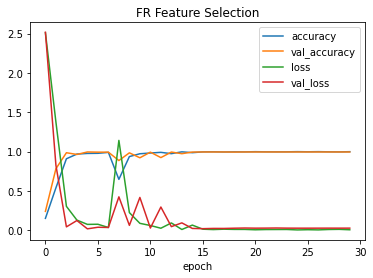

In [24]:
plt.plot(history.history['acc'],label="accuracy")
plt.plot(history.history['val_acc'],label="val_accuracy")
plt.plot(history.history['loss'],label="loss")
plt.plot(history.history['val_loss'],label="val_loss")
plt.legend()
plt.title("FR Feature Selection")
plt.xlabel('epoch')


## Save the model/weights

In [25]:
# JSON JSON
# serialize model to json
json_model = model.to_json()

# save the model architecture to JSON file
with open('{}/{}.model.json'.format(output_dir, model_name), 'w') as json_file:
    json_file.write(json_model)


# YAML YAML
# serialize model to YAML
model_yaml = model.to_yaml()

# save the model architecture to YAML file
with open("{}/{}.model.yaml".format(output_dir, model_name), "w") as yaml_file:
    yaml_file.write(model_yaml)


# WEIGHTS HDF5
# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir,model_name))
print("Saved model to disk")

Saved model to disk


In [26]:
# Open the handle
json_file = open('{}/{}.model.json'.format(output_dir, model_name), 'r')

# load json and create model
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded model from disk")
# loaded_model_json

Loaded model from disk


In [27]:
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='sgd', 
                     metrics=['accuracy'])
score = loaded_model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Test score: 0.026441169902682304
Test accuracy: 0.9951515197753906
accuracy: 99.52%
